In [1]:
import numpy as np
import scipy
import scipy.signal as signal
import matplotlib.pyplot as plt

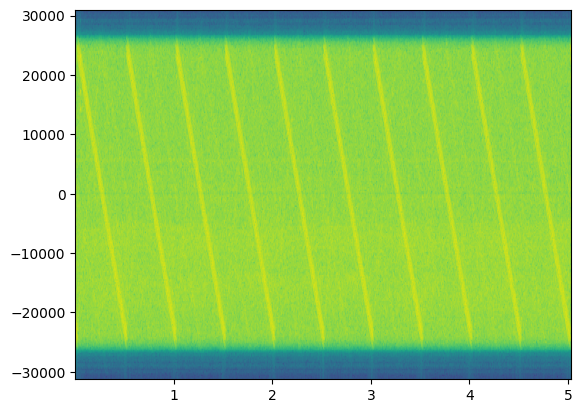

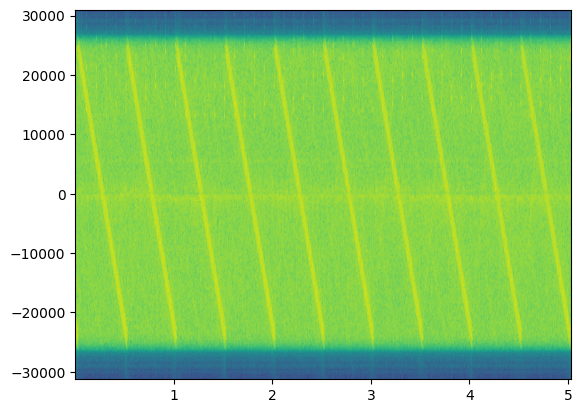

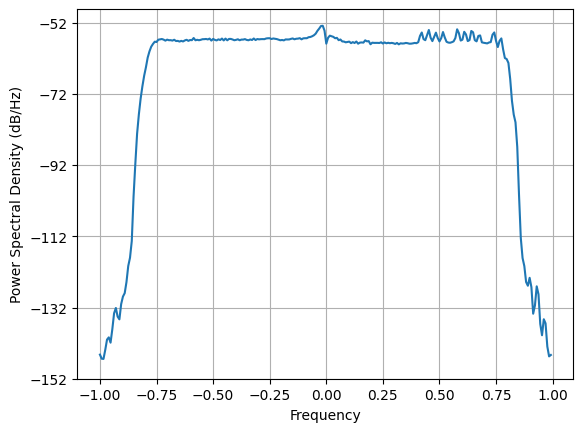

In [4]:
#######################################################################################################
#This notebook is for quick radar sweep analysis
#Ignore the delta/adjustment stuff unless you need to shift the read in file to align the sweeps to pps
#Rewrite the way you read in the data if you are not using binary files
####################################################################################################### 
'''
delta = 0.644146
if delta >= 1. :
    adjustment = round((2.-delta)*8*62500*4)
if delta < 1. :
    adjustment = round((1.-delta)*8*62500*4)

if (adjustment % 2) == 1:
    adjustment += 1
if (adjustment % 4) == 2:
    adjustment -= 2
'''
fr = "/Users/lfc/Documents/B210_CODAR/0215/1707991201_CARL_20240215_1000_13475.0_62500.0_--LOOPS_B210--_0.byn"
datarough = np.nan_to_num(np.fromfile(fr, dtype="float32",offset=62500*8 - 17560, count = -1))
x = np.complex64(datarough[0::2] + 1j*datarough[1::2])



fe = "/Users/lfc/Documents/B210_CODAR/0215/1707991801_CARL_20240215_1010_13475.0_62500.0_--LOOPS_B210--_0.byn"
y = np.nan_to_num(np.fromfile(fe, dtype="float32",offset=62500*8 - 17560 , count = -1))
y = np.complex64(y[0::2] + 1j*y[1::2])

plt.figure(0)
plt.specgram(x,NFFT=256,Fs=62500)
plt.figure(1)
plt.specgram(y,NFFT=256,Fs=62500)
plt.figure(2)
plt.psd(y)
plt.show()

f0,f1 24814.844 0.7940750080015277
f0,f1 24814.844 0.7940750080015277


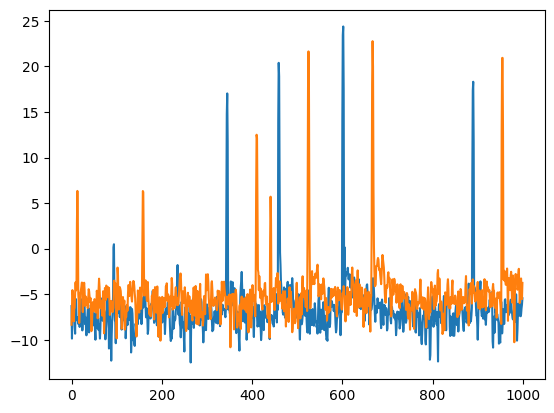

In [25]:
#function to dechirp a CODAR signal
def dechirp(x,Fs = 62500,Tipp = 0.5,BW = -49.62968800*1e3):
    # sampleRate = 62500.
    T_Sweep =Tipp # s.
    
    # make the matched filter
    
    nSamplesPerSweep = int(Fs*T_Sweep)
    t1 = np.arange(0,nSamplesPerSweep,1)/float(Fs)
    #print(t1.shape, t1)

    #     BW = -25.73391300*1e3 # Hz
    #BW = -25.739*1e3
    f0 = abs(BW)/2. # Hz
    #     Tipp = 1. # Hz
    f = f0+(BW*t1/(2*T_Sweep))
    print('f0,f1', f[0],f[-1])
    ymf = np.exp(2j*np.pi*f*t1)


    tInterval = int(x.shape[0]/nSamplesPerSweep)
    x = x[0:tInterval*nSamplesPerSweep]
    # print('tInterval', tInterval, x.shape)
    x1 = x.reshape([tInterval,nSamplesPerSweep])
    xout = np.zeros(x1.shape).astype('complex64')
    Wn = scipy.signal.windows.hann(nSamplesPerSweep)

    for i in range(x1.shape[0]):
        FTx = np.fft.fft(x1[i,:]*Wn)
        FTmf = np.fft.fft(ymf)
        xout[i,:] = np.fft.ifft(np.conj(FTmf)*FTx)

    #Range = (3.e8*t1)/1000.
    Range = t1*62500
    Power = np.sum(xout*np.conj(xout), axis=0)
    # print('Power', Power)
    # print('xout', xout)
    #plt.plot(Power)

    return Range[0:1000] ,Power[0:1000] 

rsp_range, rsp_power = dechirp(x)
ettus_range, ettus_power = dechirp(y)

plt.plot(rsp_range,10*np.log10(rsp_power))
plt.plot(ettus_range,10*np.log10(ettus_power))
plt.show()

(array([[2.76990148e-20, 2.48995070e-19, 6.16439338e-20, ...,
         3.77032473e-19, 1.16827002e-19, 6.39221853e-20],
        [2.49435620e-20, 7.95981667e-20, 3.83556792e-20, ...,
         3.52133743e-19, 2.34227716e-19, 1.24973963e-19],
        [2.46368619e-20, 1.04404740e-19, 2.54511655e-20, ...,
         2.26542258e-19, 1.97570972e-19, 7.79137985e-20],
        ...,
        [7.66325128e-20, 9.81951181e-20, 3.64686373e-20, ...,
         6.43049580e-19, 6.33609429e-19, 3.76143822e-19],
        [1.05471223e-20, 2.05556098e-19, 1.86283728e-20, ...,
         3.66629267e-19, 1.96166139e-19, 1.50129179e-19],
        [1.02367541e-22, 5.12641722e-20, 8.28503694e-20, ...,
         2.66384452e-19, 2.75404563e-19, 1.27467653e-19]]),
 array([-31250.      , -31005.859375, -30761.71875 , -30517.578125,
        -30273.4375  , -30029.296875, -29785.15625 , -29541.015625,
        -29296.875   , -29052.734375, -28808.59375 , -28564.453125,
        -28320.3125  , -28076.171875, -27832.03125 , -27587.8

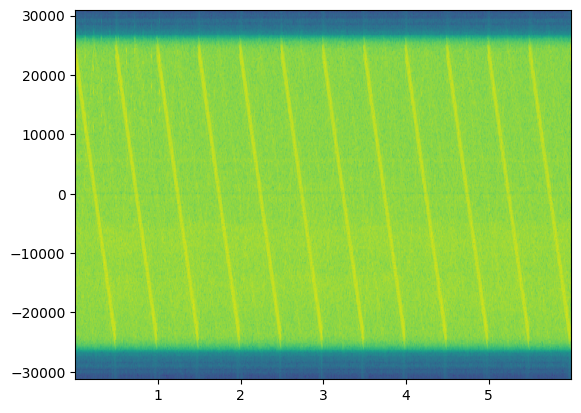

In [7]:
#alternate way of importing binary data
#example is using shorts instead of float32 
dtype = np.dtype([('re',np.short),('im',np.short)])
data = np.fromfile(fr,dtype=dtype,offset=0,count=-1)
x = data.view(np.complex64)
